#### Explainability of BiLSTM using Attention

In [ ]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'master'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive

    drive.mount('/content/drive')

In [ ]:
import torch

import pandas as pd
from utils.constants import DATA_PATH, GLOVE_PATH

DATA_PATH

In [ ]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = 'cpu'

In [3]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [4]:
from preprocess.data_loader import load_glove_embeddings

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [5]:
# Load the trained BiLSTM model
from models.bilstm import BiLSTMSpam

model_path = DATA_PATH + '/trained-models/spam_bilstm_final.pt'
model = BiLSTMSpam(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                   pretrained_embeddings=pretrained_embeddings)
model.load(model_path, map_location=torch.device('cpu'))
model = model.to(device)
model.eval()

BiLSTMSpam(
  (embedding): Embedding(25245, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
from utils.functions import encode

# Prepare test data
X_test_tensor = torch.tensor([encode(t, word2idx, max_len) for t in test_df['text']])
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [7]:
# Get model predictions
with torch.no_grad():
    model_output = model(X_test_tensor)
    # If model returns a tuple, use the first element (typically the predictions)
    if isinstance(model_output, tuple):
        y_pred_probs = model_output[0]
    else:
        y_pred_probs = model_output

    y_pred = (y_pred_probs > 0.5).float()

#### Attention for BiLSTM

In [8]:
# Generate Attention explanations and compute quality metrics
from explainability.BiLSTMAttentionMetrics import BiLSTMAttentionMetrics

# Initialize the metrics calculator
attention_metrics = BiLSTMAttentionMetrics(
    model=model,
    word2idx=word2idx,
    idx2word=idx2word,
    max_len=max_len,
    device=device
)

print("BiLSTM Attention Metrics Calculator initialized successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Metrics calculator device: {attention_metrics.device}")


BiLSTM Attention Metrics Calculator initialized successfully!
Model device: cpu
Metrics calculator device: cpu


In [9]:
samples = (150, 357, 402 , 416, 417, 604)
# display elements in the test set with the given indices
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"


In [10]:
# Let's compute explanation quality metrics for a few sample texts
metrics = []
for i in samples:
    text = test_df['text'].iloc[i]
    subject = test_df['subject'].iloc[i]
    label = ("Spam" if test_df['label'].iloc[i] == 1 else "Ham")
    print("=" * 100)
    print(f"Subject: {subject}. Label: {label}, Predicted: {y_pred[i].item():.2f}")
    print("=" * 100)
    metric = attention_metrics.evaluate_all_metrics(
        text=text,
        steps=15,  # Number of steps for AUC calculations
        k=5,       # Number of top features for comprehensiveness
        num_perturbations=8,  # Number of perturbations for stability
        perturbation_prob=0.1  # Probability of perturbing each token
    )
    metrics.append(metric)

Subject: Seeing is believing. Label: Ham, Predicted: 0.00
Evaluating metrics for text: seeing believing url <URL> author linda grant neve...
AUC-Del: 0.8448
AUC-Ins: 0.5307
Comprehensiveness: 1.0000
Jaccard Stability: 0.7917
Subject: Apple Store eNews : November 2002. Label: Ham, Predicted: 0.00
Evaluating metrics for text: apple store enews november 2002 you appear using e...
AUC-Del: 0.4669
AUC-Ins: 0.6053
Comprehensiveness: 0.0046
Jaccard Stability: 0.6086
Subject: RE: [ILUG] NVIDIA and Debian Woody. Label: Ham, Predicted: 0.00
Evaluating metrics for text: re ilug nvidia debian woody hi there now probably ...
AUC-Del: 0.4609
AUC-Ins: 0.0984
Comprehensiveness: 0.0000
Jaccard Stability: 0.5099
Subject: The Flight to Safety is Upon Us. Label: Spam, Predicted: 1.00
Evaluating metrics for text: flight safety upon us s not rush hour traffic s fl...
AUC-Del: 0.9155
AUC-Ins: 1.0000
Comprehensiveness: 0.0000
Jaccard Stability: 0.4385
Subject: Low cost quality conference calls. Label: Spam, P

In [11]:
subjects = test_df['subject'].iloc[list(samples)]
metrics_df = pd.DataFrame(metrics)
metrics_df

,auc_deletion,auc_insertion,comprehensiveness,jaccard_stability
0,0.844816,0.530706,1.000000e+00,0.791667
1,0.466878,0.605263,4.648627e-03,0.608631
2,0.460899,0.098434,1.357357e-07,0.509921
3,0.915511,1.000000,0.000000e+00,0.438492
4,0.562121,0.999999,3.576279e-07,0.690476
5,0.680699,1.000000,0.000000e+00,0.473214


In [ ]:
# Compute overall explanation quality metrics
metrics_df, overall_metrics, spam_metrics, ham_metrics = attention_metrics.calculate_overall_metrics(test_df)
metrics_df

In [15]:
metrics_df

,auc_deletion,auc_insertion,comprehensiveness,jaccard_stability,true_label,predicted_prob
0,0.811254,0.356791,1.884820e-02,0.441270,0,7.993815e-06
1,0.999986,0.999999,2.264977e-06,0.933333,1,1.000000e+00
2,0.951075,0.146152,9.999602e-01,0.619048,1,3.969522e-05
3,0.785732,0.796212,9.999870e-01,0.933333,0,2.100235e-09
4,0.855172,0.144880,3.637819e-08,0.752381,0,8.792771e-10
...,...,...,...,...,...,...
93,0.999989,0.999999,1.049042e-05,0.424603,1,1.000000e+00
94,0.844829,0.147346,5.392494e-06,0.277778,0,7.333076e-08
95,0.785732,0.796212,9.999870e-01,1.000000,0,2.100235e-09
96,0.608411,0.551140,3.647346e-07,0.554762,0,1.041187e-08


In [16]:
overall_metrics

{'mean': auc_deletion         0.748638
 auc_insertion        0.611234
 comprehensiveness    0.247781
 jaccard_stability    0.661087
 true_label           0.346939
 predicted_prob       0.346949
 dtype: float64,
 'median': auc_deletion         7.857322e-01
 auc_insertion        7.166749e-01
 comprehensiveness    1.132333e-06
 jaccard_stability    6.396825e-01
 true_label           0.000000e+00
 predicted_prob       1.465470e-08
 dtype: float64,
 'std': auc_deletion         0.220761
 auc_insertion        0.351215
 comprehensiveness    0.421584
 jaccard_stability    0.232576
 true_label           0.478443
 predicted_prob       0.478433
 dtype: float64}

In [17]:
spam_metrics

auc_deletion         0.878995
auc_insertion        0.974886
comprehensiveness    0.076916
jaccard_stability    0.604318
true_label           1.000000
predicted_prob       0.970585
dtype: float64

In [18]:
ham_metrics

auc_deletion         0.679386
auc_insertion        0.418044
comprehensiveness    0.338553
jaccard_stability    0.691245
true_label           0.000000
predicted_prob       0.015643
dtype: float64

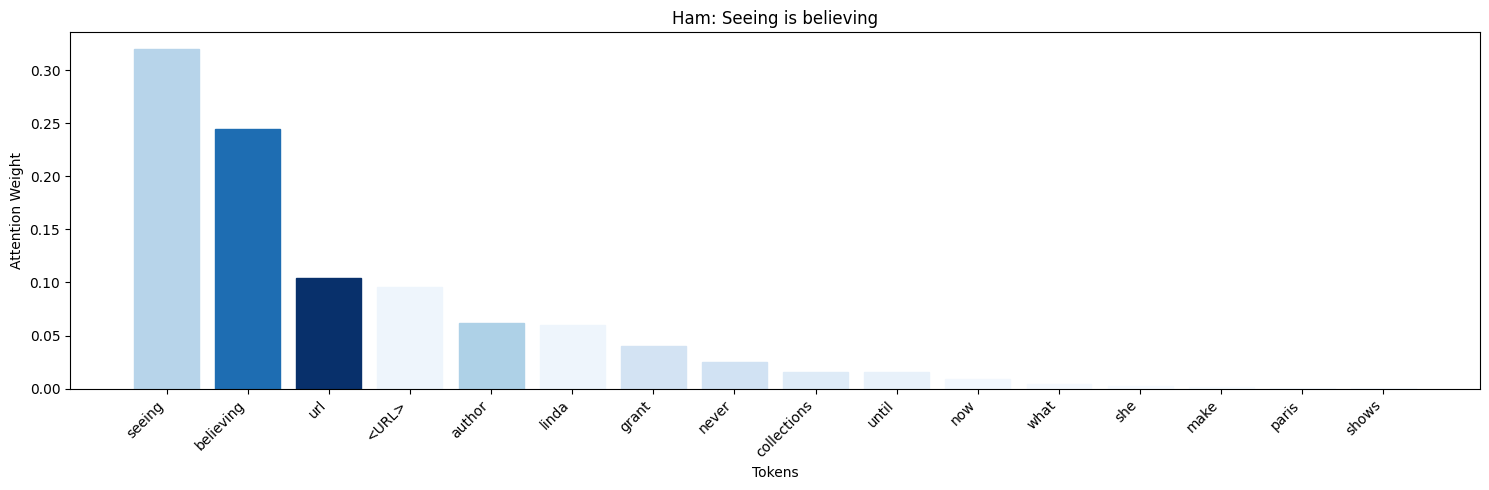

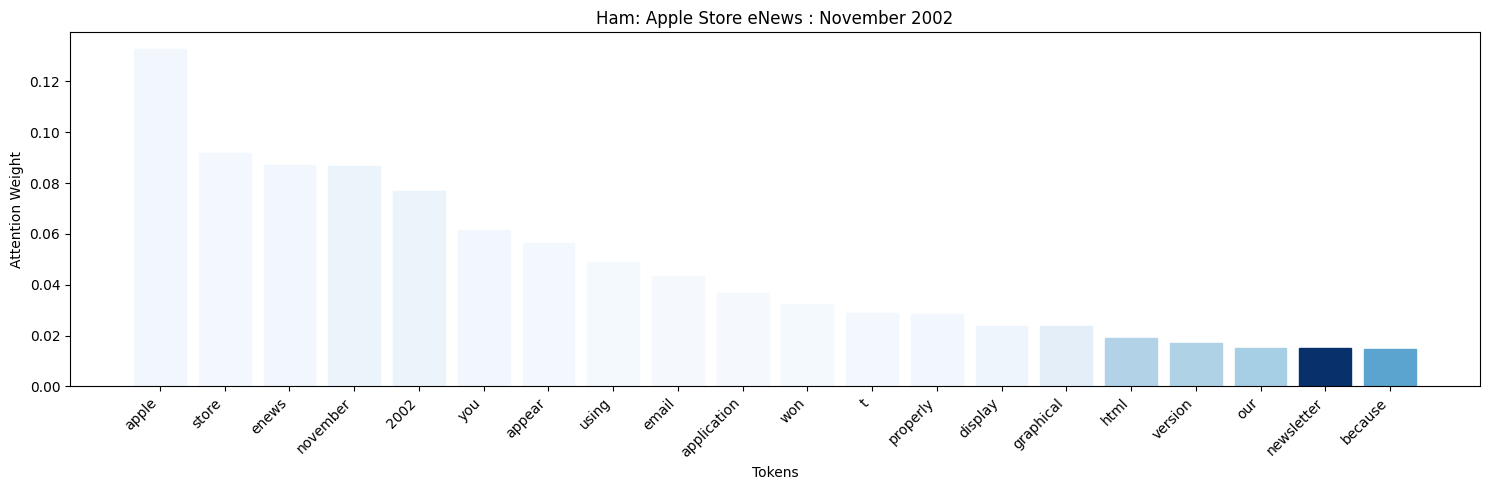

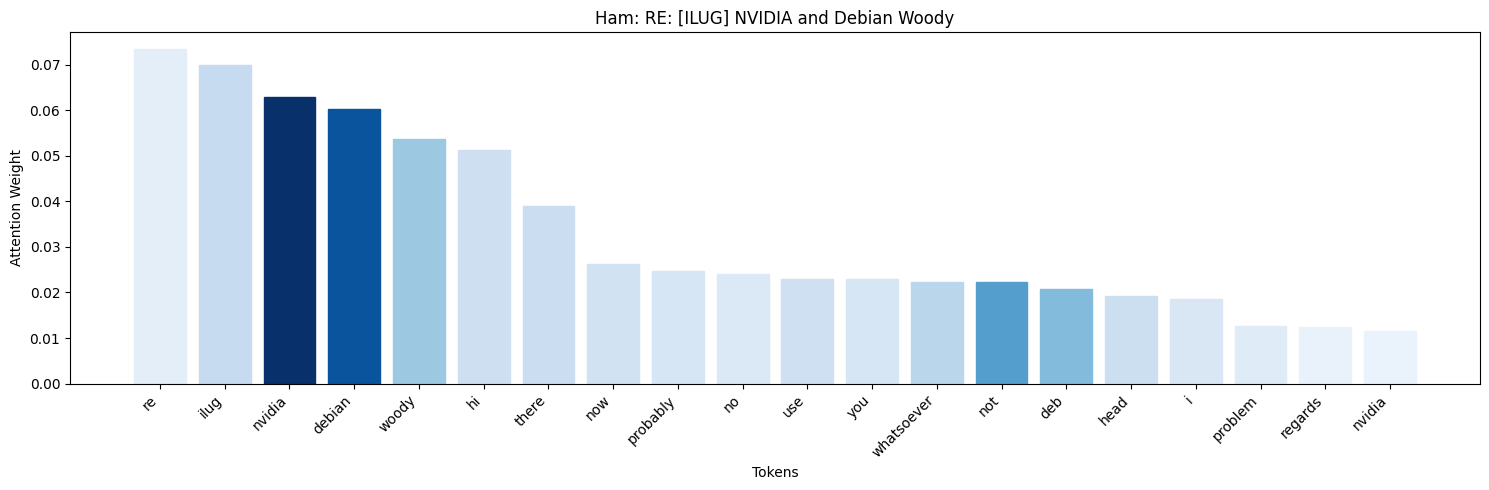

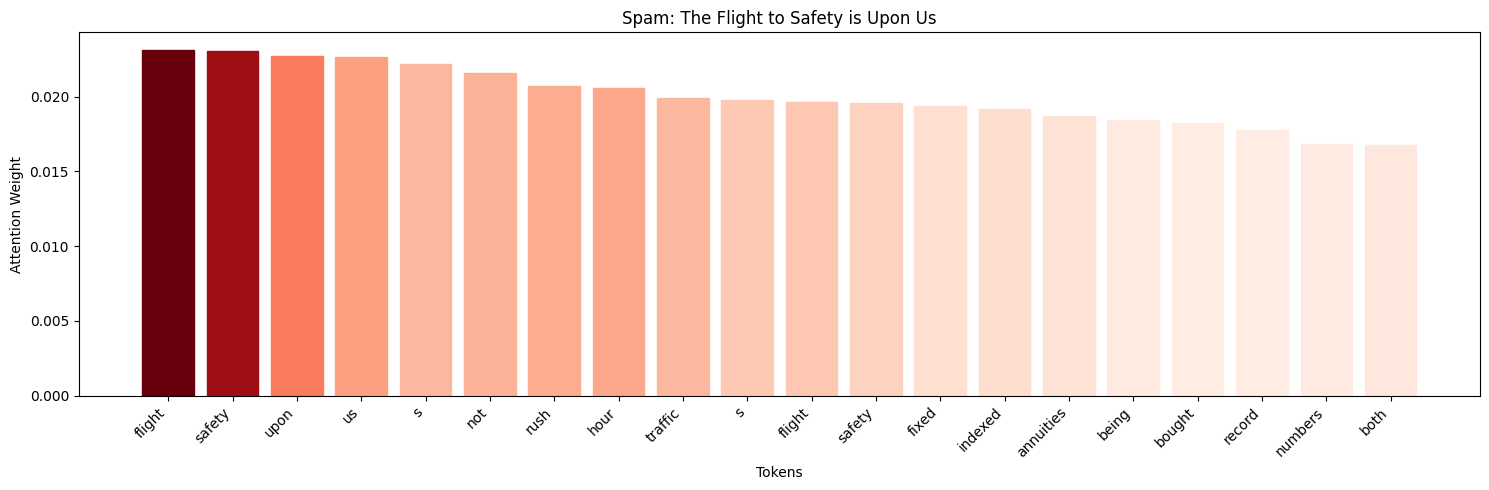

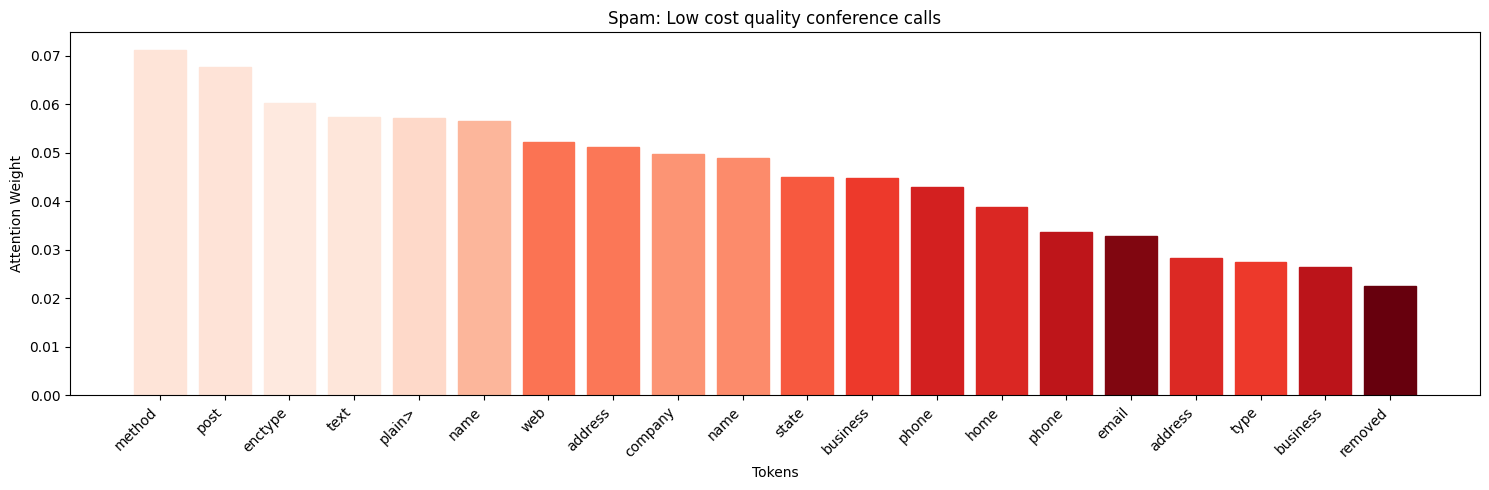

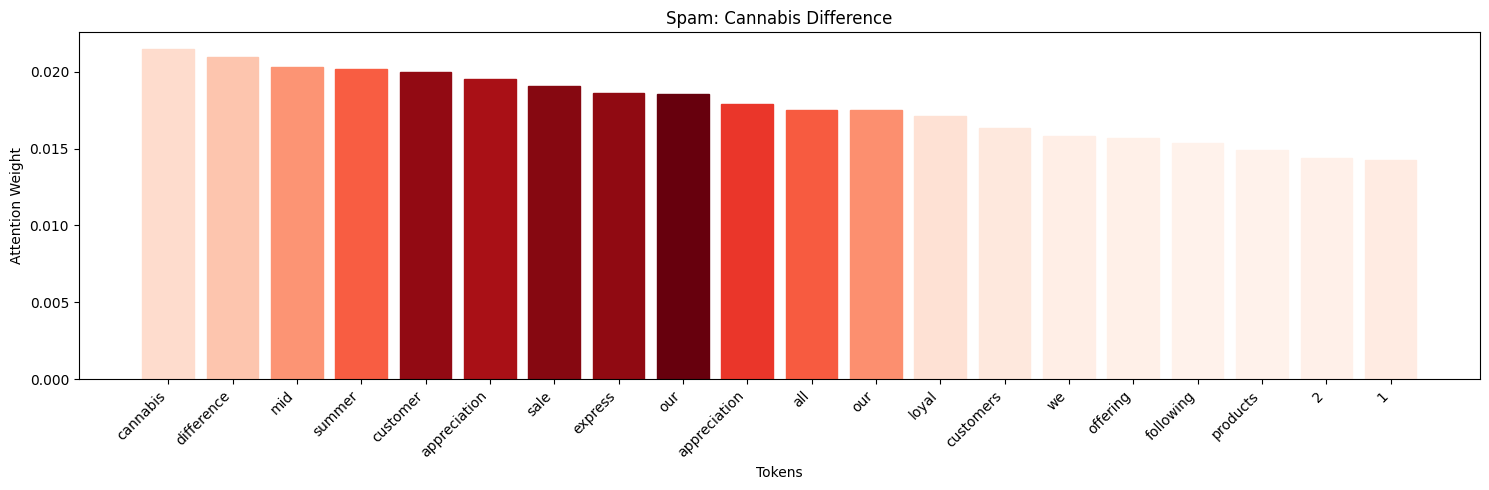

In [27]:
# Visualize attention weights for both examples
import matplotlib.pyplot as plt

index = 1
for i in samples:
    plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, index)
    index = 2 if index == 1 else 1  # Toggle between 1 and 2
    text = test_df['text'].iloc[i]
    subject = test_df['subject'].iloc[i]
    label = test_df['label'].iloc[i]
    label_str = "Spam" if label == 1 else "Ham"
    attention_weights = attention_metrics._get_attention_weights(text)
    tokens = text.split()[:min(20, len(text.split()))]  # Show first 20 tokens
    weights = attention_weights[:len(tokens)]
    all_tokens = text.split()
    all_weights = attention_weights[:len(all_tokens)]
    rankings = attention_metrics._get_token_importance_ranking(text, attention_weights)
    ranked_tokens = []
    ranked_weights = []
    for i, (idx, weight) in enumerate(rankings[:20]):
        token = text.split()[idx] if idx < len(text.split()) else "<PAD>"
        ranked_tokens.append(token)
        ranked_weights.append(weight)

    bars1 = plt.bar(range(len(tokens)), ranked_weights)
    plt.xlabel('Tokens')
    plt.ylabel('Attention Weight')
    plt.title(f"{label_str}: {subject}")
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')

    # Color bars based on attention weight
    if label == 1:
        max_weight = max(weights)
        for i, bar in enumerate(bars1):
            bar.set_color(plt.cm.Reds(weights[i] / max_weight))
    else:
        max_weight = max(weights)
        for i, bar in enumerate(bars1):
            bar.set_color(plt.cm.Blues(weights[i] / max_weight))


    plt.tight_layout()
    plt.show()

In [28]:
# Demonstrate individual metric calculations with detailed explanations

# Let's use a shorter text for demonstration to see the effects more clearly
demo_text = "FREE money now! Click here to claim your prize!"
print(f"Demo text: {demo_text}")
print(f"Text length: {len(demo_text.split())} tokens")

# Get prediction for demo text
demo_encoded = attention_metrics._encode_text(demo_text)
demo_pred = attention_metrics._get_prediction(demo_encoded)
print(f"Model prediction: {demo_pred:.4f} (spam probability)")

print("\n" + "=" * 60)
print("DETAILED METRIC CALCULATIONS")
print("=" * 60)

# 1. AUC-Del demonstration
print("\n1. AUC-DELETION (AUC-Del)")
print("=" * 30)
print("This metric measures how much the prediction drops when we remove")
print("the most important features according to attention weights.")
print("Lower values indicate better explanations.")

auc_del = attention_metrics.compute_auc_deletion(demo_text, steps=10)
print(f"AUC-Del score: {auc_del:.4f}")

# 2. AUC-Ins demonstration  
print("\n2. AUC-INSERTION (AUC-Ins)")
print("=" * 30)
print("This metric measures how much the prediction improves when we")
print("progressively add the most important features.")
print("Higher values indicate better explanations.")

auc_ins = attention_metrics.compute_auc_insertion(demo_text, steps=10)
print(f"AUC-Ins score: {auc_ins:.4f}")

# 3. Comprehensiveness demonstration
print("\n3. COMPREHENSIVENESS")
print("=" * 30)
print("This metric measures the prediction change when removing the")
print("top-k most important features. Higher values indicate better explanations.")

for k in [1, 3, 5]:
    comp = attention_metrics.compute_comprehensiveness(demo_text, k=k)
    print(f"Comprehensiveness (k={k}): {comp:.4f}")

# 4. Jaccard Stability demonstration
print("\n4. JACCARD STABILITY")
print("=" * 30)
print("This metric measures how consistent the top-k important features")
print("are across perturbed versions of the input.")
print("Higher values indicate more stable explanations.")

jaccard = attention_metrics.compute_jaccard_stability(demo_text, num_perturbations=5, k=3)
print(f"Jaccard Stability: {jaccard:.4f}")

print("\n" + "=" * 60)
print("All metrics calculated successfully!")
print("These metrics help evaluate the quality and reliability of")
print("attention-based explanations for the BiLSTM model.")
print("=" * 60)

Demo text: FREE money now! Click here to claim your prize!
Text length: 9 tokens
Model prediction: 1.0000 (spam probability)

DETAILED METRIC CALCULATIONS

1. AUC-DELETION (AUC-Del)
This metric measures how much the prediction drops when we remove
the most important features according to attention weights.
Lower values indicate better explanations.
AUC-Del score: 1.0000

2. AUC-INSERTION (AUC-Ins)
This metric measures how much the prediction improves when we
progressively add the most important features.
Higher values indicate better explanations.
AUC-Ins score: 1.0000

3. COMPREHENSIVENESS
This metric measures the prediction change when removing the
top-k most important features. Higher values indicate better explanations.
Comprehensiveness (k=1): 0.0000
Comprehensiveness (k=3): 0.0000
Comprehensiveness (k=5): 0.0000

4. JACCARD STABILITY
This metric measures how consistent the top-k important features
are across perturbed versions of the input.
Higher values indicate more stable expl

# BiLSTM Attention-Based Explanation Quality Metrics

### ✅ Implemented Metrics:

1. **AUC-Del (Area Under Deletion Curve)**
   - **What it measures**: How prediction confidence drops when removing features in order of importance
   - **Interpretation**: Lower values indicate better explanations (important features cause bigger drops)
   - **Implementation**: Uses attention weights to rank tokens, progressively removes most important ones

2. **AUC-Ins (Area Under Insertion Curve)**
   - **What it measures**: How prediction confidence improves when adding features in order of importance
   - **Interpretation**: Higher values indicate better explanations (important features cause bigger improvements)
   - **Implementation**: Starts with masked input, progressively adds most important tokens

3. **Comprehensiveness**
   - **What it measures**: Absolute prediction change when removing top-k most important features
   - **Interpretation**: Higher values indicate better explanations (removing important features significantly changes prediction)
   - **Implementation**: Compares original prediction with prediction after masking top-k attended tokens

4. **Jaccard Stability**
   - **What it measures**: Consistency of top-k important features across perturbed inputs
   - **Interpretation**: Higher values indicate more stable/reliable explanations
   - **Implementation**: Compares attention-based rankings between original and perturbed texts

## Key Advantages of Attention-Based Metrics:

- **Model-agnostic within attention models**: Works with any model that outputs attention weights
- **Computationally efficient**: No need for complex gradient calculations or external explainers
- **Direct interpretability**: Attention weights directly indicate token importance
- **Real-time capability**: Fast computation suitable for interactive applications

## Usage:

The `BiLSTMAttentionMetrics` class provides a complete implementation that can be easily integrated into model evaluation pipelines or used for interactive explanation analysis.